# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [121]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

# magic word for producing visualizations in notebook
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('/Users/mhashimoto/anaconda2/projects/files/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('/Users/mhashimoto/anaconda2/projects/files/Udacity_CUSTOMERS_052018.csv', sep=';')
dias_xls = pd.read_excel('/Users/mhashimoto/anaconda2/projects/files/DIAS Attributes - Values 2017.xlsx', header = 1)
dias_info_level = pd.read_excel('/Users/mhashimoto/anaconda2/projects/files/DIAS Information Levels - Attributes 2017.xlsx', header = 1)

/Users/mhashimoto/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(azdias.iloc[:,18:20].columns)
print(customers.iloc[:,18:20].columns)

def data_cleanup(df):
    cols = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
    df[cols] = df[cols].replace({'X': np.nan, 'XX': np.nan})
    df[cols] = df[cols].astype(float)

    return df

def dias_cleanup(df):
    df.drop(columns=['Unnamed: 0'], inplace=True)
    return df

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')
Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')


In [4]:
dias_xls_cleaned = dias_cleanup(dias_xls)
dias_xls_cleaned['Attribute'] = dias_xls_cleaned['Attribute'].fillna(method='ffill')

dias_info_cleaned = dias_cleanup(dias_info_level)
dias_info_cleaned['Information level'] = dias_info_cleaned['Information level'].fillna(method='ffill')

azdias_cleaned = data_cleanup(azdias)
customers_cleaned = data_cleanup(customers)

customers_cleaned = customers_cleaned.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=False, axis=1)

In [5]:
attributes = dias_xls_cleaned['Attribute'].unique().tolist()
attr_azdias = list(azdias.columns)
attr_common = np.intersect1d(attributes, attr_azdias)
attr_common

array(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ALTER_HH', 'ANREDE_KZ',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'BALLRAUM', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CJT_GESAMTTYP',
       'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM',
       'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM',
       'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ANZ_12',
       'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_TELKO_ANZ_12',
       'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM',
       'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_ANZ_12',
       'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM',
       'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
       'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12',
       'D19_VERSI_ANZ_24', 'EWDICHTE', 'FINANZTYP', 'FINANZ_ANLEGER',
       'FINANZ_HAUSBAUER', 'FINANZ_MINIMA

In [6]:
print("# of attributes in azdias: " + str(len(attr_azdias)))
print("# of attributes in DIAS Attributes: " + str(len(attributes)))
print("# of common attributes in both data: " + str(len(attr_common)))

# of attributes in azdias: 366
# of attributes in DIAS Attributes: 314
# of common attributes in both data: 272


In [7]:
unknown = dias_xls_cleaned.loc[np.where(dias_xls_cleaned['Meaning'].str.contains('unknown'))]['Meaning'].unique()
unknown_meaning = dias_xls_cleaned[dias_xls_cleaned['Meaning'].isin(unknown)]

unknown_meaning

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
...,...,...,...,...
2219,WOHNDAUER_2008,length of residence,"-1, 0",unknown
2229,WOHNLAGE,residential-area,-1,unknown
2238,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,"-1, 0",unknown
2244,W_KEIT_KIND_HH,likelihood of a child present in this household,"-1, 0",unknown


In [8]:
azdias_copy = azdias_cleaned.copy()
customers_copy = customers_cleaned.copy()
for row in unknown_meaning.iterrows():
    attribute = row[1]['Attribute']
    value = row[1]['Value']
    
    if attribute in azdias_copy.columns:
        if isinstance(value, int):
            azdias_copy[attribute].replace(value, np.nan, inplace=True)
            customers_copy[attribute].replace(value, np.nan, inplace=True)
        elif isinstance(value, str):
            azdias_copy[attribute].replace(str(value), np.nan, inplace=True)
            customers_copy[attribute].replace(str(value), np.nan, inplace=True)

In [9]:
# Find attributes with more than 30% null data
missing_val_azdias = pd.DataFrame(data = azdias_copy.isnull().mean(), columns = ['null_percentage'])
missing_val_customers = pd.DataFrame(data = customers_copy.isnull().mean(), columns = ['null_percentage'])

azdias_over30 = missing_val_azdias[missing_val_azdias['null_percentage'] > 0.3]
customers_over30 = missing_val_customers[missing_val_customers['null_percentage'] > 0.3]

In [10]:
# Find unique attributes (with more than 30% null data) between customers and azdias
np.setdiff1d(customers_over30.index, azdias_over30.index)
np.setdiff1d(azdias_over30.index, customers_over30.index)

# Find common attributes between customers and azdias in order to drop them
common_attr = np.intersect1d(customers_over30.index, azdias_over30.index)
common_attr

array(['LP_FAMILIE_GROB'], dtype=object)

array([], dtype=object)

array(['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2',
       'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP',
       'LP_STATUS_GROB'], dtype=object)

In [11]:
# Drop attributes with more than 30% null data
azdias_copy = azdias_copy.drop(common_attr, axis=1)
customers_copy = customers_copy.drop(common_attr, axis=1)
#customers_copy.isnull().mean().hist()

In [12]:
# Find attributes with object type (for preprocessing)
types_customers = pd.DataFrame(data = customers_copy.dtypes, columns = ['types'])
customers_object = types_customers[types_customers['types'] == 'object']
customers_copy[customers_object.index]

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,1A,D19_UNBEKANNT,1992-02-12 00:00:00,W
1,NaN,D19_BANKEN_GROSS,NaN,NaN
2,5D,D19_UNBEKANNT,1992-02-10 00:00:00,W
3,4C,D19_NAHRUNGSERGAENZUNG,1992-02-10 00:00:00,W
4,7B,D19_SCHUHE,1992-02-12 00:00:00,W
...,...,...,...,...
191647,1C,D19_BANKEN_REST,1992-02-10 00:00:00,W
191648,5B,D19_UNBEKANNT,1997-03-06 00:00:00,W
191649,4D,D19_TECHNIK,1992-02-10 00:00:00,W
191650,4C,D19_BANKEN_REST,1992-02-10 00:00:00,W


In [13]:
# Find attributes with object type (for preprocessing)
types_azdias = pd.DataFrame(data = azdias_copy.dtypes, columns = ['types'])
azdias_object = types_azdias[types_azdias['types'] == 'object']
azdias_copy[azdias_object.index]

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN
1,8A,NaN,1992-02-10 00:00:00,W
2,4C,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,D19_SCHUHE,1992-02-12 00:00:00,W
...,...,...,...,...
891216,7A,D19_HAUS_DEKO,1992-02-10 00:00:00,W
891217,9D,D19_UNBEKANNT,1992-02-10 00:00:00,W
891218,4C,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W
891219,9D,D19_UNBEKANNT,1992-02-12 00:00:00,W


In [14]:
def pre_processing(df):
    
    df['EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM']).dt.year
    
    label_encoder = LabelEncoder()
    df['D19_LETZTER_KAUF_BRANCHE'] = label_encoder.fit_transform(df['D19_LETZTER_KAUF_BRANCHE'].astype(str))

    fill_data_CAMEO = df['CAMEO_DEU_2015'].value_counts().idxmax()
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].fillna(fill_data_CAMEO)
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace('XX', fill_data_CAMEO)
    df['CAMEO_DEU_2015'] = label_encoder.fit_transform(df['CAMEO_DEU_2015'])
    
    fill_data_OST = df['OST_WEST_KZ'].value_counts().idxmax()
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].fillna(fill_data_OST)
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].astype(str).replace({'W': 1, 'O': 2, np.nan: fill_data_OST})
    
    imputer = SimpleImputer(strategy = 'most_frequent')
    imputed_df = pd.DataFrame(imputer.fit_transform(df), index = df.index, columns = df.columns)
    return imputed_df

In [15]:
processed_customers = pre_processing(customers_copy).drop('LNR', axis=1, inplace=False)
processed_azdias = pre_processing(azdias_copy).drop('LNR', axis=1, inplace=False)

In [16]:
# Scaling with MinMaxScaler
azdias_MMS = pd.DataFrame(MinMaxScaler().fit_transform(processed_azdias), columns=processed_azdias.columns)
customers_MMS = pd.DataFrame(MinMaxScaler().fit_transform(processed_customers), columns=processed_customers.columns)

In [17]:
# Principal component analysis
num_comp_azdias = len(azdias_MMS.columns.values)
num_comp_customers = len(customers_MMS.columns.values)

pca_azdias = PCA(num_comp_azdias)
pca_customers = PCA(num_comp_customers)

pca_azdias_MMS = pca_azdias.fit(azdias_MMS)
pca_customers_MMS = pca_customers.fit(customers_MMS)


In [18]:
def scree_plot(scaled_data):
    plt.subplot(1,1,1)
    plt.plot(np.cumsum(scaled_data.explained_variance_ratio_))
    plt.xlabel('Number of components')
    plt.ylabel('Explained variance ratio')
    plt.title('Explained variance ratio vs Number of MMS components')
    plt.grid(b=True)
    plot = plt.show()

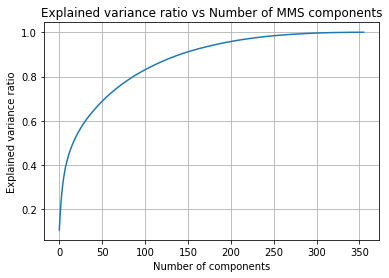

In [19]:
scree_plot(pca_azdias_MMS)

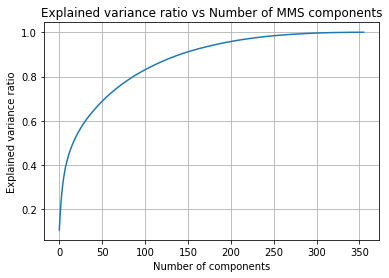

In [20]:
scree_plot(pca_azdias_MMS)

In [21]:
pca = PCA(n_components=200)
azdias_pca = pca.fit_transform(azdias_MMS)

In [23]:
centers = []
scores = []

for cluster in range(2, 15, 1):
    kmean = KMeans(cluster)
    model = kmean.fit(azdias_pca)
    centers.append(cluster)
    scores.append(np.abs(model.score(azdias_pca)))

Text(0.5, 0, 'Number of K')

Text(0, 0.5, 'Score')

Text(0.5, 1.0, 'Score vs Number of K')

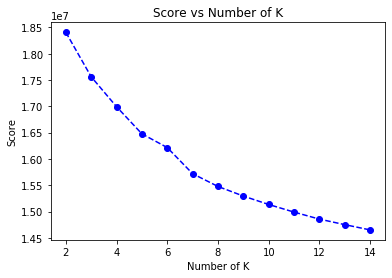

In [82]:
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('Number of K');
plt.ylabel('Score');
plt.title('Score vs Number of K')

In [25]:
kmeans = KMeans(7)
k_model = kmeans.fit(azdias_pca)
azdias_pred = kmeans.predict(azdias_pca)


In [26]:
customers_pca = pca.fit_transform(customers_MMS)
customers_pred = kmeans.predict(customers_pca)

In [27]:
counts_cluster_gen = pd.Series(azdias_pred).value_counts()
prop_cluster_general = counts_cluster_gen/len(azdias_pred)

counts_cluster_customer = pd.Series(customers_pred).value_counts()
prop_cluster_customer = counts_cluster_customer/len(customers_pred)


Text(0, 0.5, 'Proportion of people in each cluster')

<function matplotlib.pyplot.show(*args, **kw)>

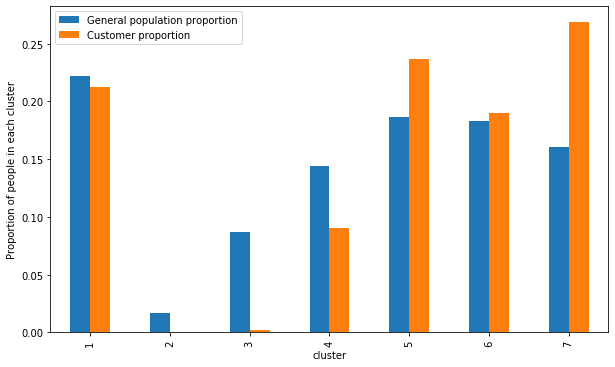

In [28]:
prop = pd.DataFrame({'General population proportion': prop_cluster_general,
                    'Customer proportion': prop_cluster_customer})
prop = prop.fillna(0)
prop['cluster'] = prop.index + 1
#prop
prop.plot(x='cluster', y=['General population proportion', 'Customer proportion'], kind = 'bar', figsize = (10, 6))
plt.ylabel('Proportion of people in each cluster')
plt.show

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [133]:
mailout_train = pd.read_csv('/Users/mhashimoto/anaconda2/projects/files/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/Users/mhashimoto/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [134]:
mailout_train_cleaned = data_cleanup(mailout_train)
mailout_train_copy = mailout_train_cleaned.copy()

for row in unknown_meaning.iterrows():
    attribute = row[1]['Attribute']
    value = row[1]['Value']
    
    if attribute in mailout_train_copy.columns:
        if isinstance(value, int):
            mailout_train_copy[attribute].replace(value, np.nan, inplace=True)
        elif isinstance(value, str):
            mailout_train_copy[attribute].replace(str(value), np.nan, inplace=True)

In [135]:
target = mailout_train_copy['RESPONSE']
features = mailout_train_copy.drop(['LNR', 'RESPONSE'], axis=1)

features = features.drop(common_attr, axis=1)
processed_mailout_train = pre_processing(features)
processed_mailout_train.isnull().sum().sum()

mailout_train_MMS = pd.DataFrame(MinMaxScaler().fit_transform(processed_mailout_train), columns=processed_mailout_train.columns)

0

In [136]:
models = []
models.append(('Logistic Regression', LogisticRegression(solver='lbfgs', max_iter=10000)))
models.append(('Random Forest Classifier', RandomForestClassifier(n_estimators=100)))
models.append(('Ada Boost Classifier', AdaBoostClassifier()))
models.append(('Gradient Boosting Classifier', GradientBoostingClassifier()))

In [137]:
def plt_learning_curve(cv_score, train_score, test_score, name):
    print('Model: {}, Score mean: {:.2f}, Scores std: {:.2f}'.format(name, cv_score.mean(), cv_score.std()))
    print('roc_auc train score: {}'.format(train_score[-1].round(2)))
    print('roc_auc validation score: {}'.format(test_score[-1].round(2)))
    
    plt.grid()
    plt.title('Learning curve for {}'.format(name))
    plt.xlabel('% of training set')
    plt.ylabel('Score')
    plt.plot(np.linspace(.1, 1.0,10)*100, train_score, 'o-', color='g', label='Training score')
    plt.plot(np.linspace(.1, 1.0,10)*100, test_score, 'o-', color='r', label='Cross-validation score')
    plt.yticks(np.arange(0.45, 1.02, 0.05))
    plt.xticks(np.arange(0, 100.05, 10))
    plt.legend(loc='best')
    plt.show()

Model: Logistic Regression, Score mean: 0.67, Scores std: 0.02
roc_auc train score: 0.81
roc_auc validation score: 0.67


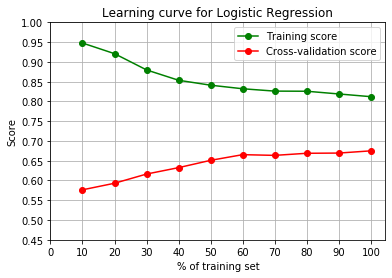

Model: Random Forest Classifier, Score mean: 0.61, Scores std: 0.02
roc_auc train score: 0.97
roc_auc validation score: 0.62


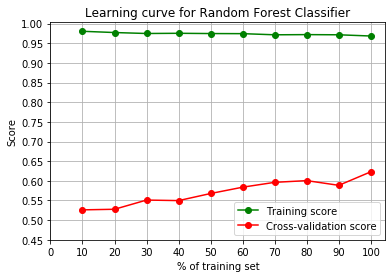

Model: Ada Boost Classifier, Score mean: 0.73, Scores std: 0.02
roc_auc train score: 0.84
roc_auc validation score: 0.73


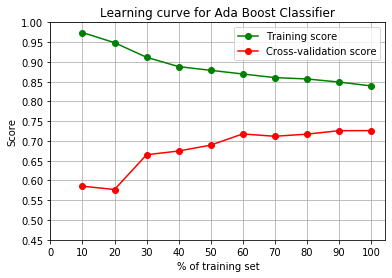

Model: Gradient Boosting Classifier, Score mean: 0.76, Scores std: 0.02
roc_auc train score: 0.91
roc_auc validation score: 0.75


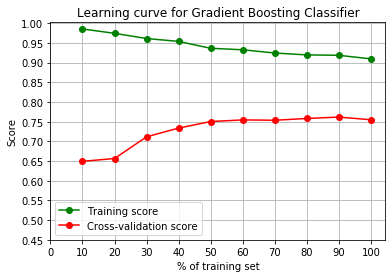

In [138]:
results = []
model_names = []
n_splits = 5
for model_name, model in models:
    #X_train, X_valid = processed_mailout_train.iloc[train_idx], processed_mailout_train.iloc[valid_idx]
    #y_train, y_valid = target.iloc[train_idx], target.iloc[valid_idx]
    #model.fit(X_train, y_train)
    #y_pred = model.predict(X_valid)
    #score = roc_auc_score(y_valid, y_pred)
    cv_results = cross_val_score(model, mailout_train_MMS, target, cv=n_splits, scoring='roc_auc', n_jobs=1)
    results.append(cv_results.mean())
    model_names.append(model_name)

    train_sizes, train_scores, test_scores = learning_curve(model, mailout_train_MMS, target, cv=n_splits, scoring='roc_auc', train_sizes=np.linspace(.1, 1.0, 10), n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt_learning_curve(cv_results, train_scores_mean, test_scores_mean, model_name)

In [139]:
score_df = pd.DataFrame({'Model': model_names, 'Score': results})
score_df

,Model,Score
0,Logistic Regression,0.674862
1,Random Forest Classifier,0.605910
2,Ada Boost Classifier,0.727178
3,Gradient Boosting Classifier,0.758261


In [140]:
X_train, X_test, y_train, y_test = train_test_split(processed_mailout_train, target, test_size=0.3, stratify=target)
GradientBoosting = GradientBoostingClassifier()
parameters = {'n_estimators': [100, 200, 500],
              "max_depth":[3,5]
             }
gridSearch_model = GridSearchCV(estimator=GradientBoosting, param_grid=parameters, cv=5, scoring='roc_auc')
gridSearch_model.fit(X_train, y_train)
gridSearch_model.best_params_, gridSearch_model.best_score_

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

({'max_depth': 3, 'n_estimators': 100}, 0.7564029222808666)

In [141]:
parameters = {"learning_rate": [0.05, 0.1, 0.15],
              "min_samples_split": [2, 3, 4],
              "min_samples_leaf": [1, 2, 3]
             }
gridSearch_model = GridSearchCV(estimator=GradientBoostingClassifier(max_depth=3,n_estimators=100),
                                param_grid=parameters,
                                cv=5,
                                scoring='roc_auc')
gridSearch_model.fit(X_train, y_train)
gridSearch_model.best_params_, gridSearch_model.best_score_

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

({'learning_rate': 0.05, 'min_samples_leaf': 2, 'min_samples_split': 2},
 0.7603820448463853)

In [142]:
tuned_model = GradientBoostingClassifier(max_depth=3,
                                        n_estimators=100,
                                        learning_rate=0.05,
                                        min_samples_leaf=2,
                                        min_samples_split=2)
tuned_model.fit(X_train, y_train)
#y_pred = tuned_model.predict(X_test)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [163]:
def plot_feature_importance(model, model_type, features, plot_n=10):
    feature_importance = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
    feature_importance = feature_importance.sort_values('importance', ascending=False).reset_index(drop=True)
    feature_importance['normalised'] = feature_importance['importance'] / feature_importance['importance'].sum()
    
    plt.figure(figsize=(10,6))
    ax = plt.subplot()
    ax.barh(list(reversed(list(feature_importance.index[:plot_n]))),
            feature_importance['normalised'][:plot_n],
            align='center', edgecolor='k'
           )
    ax.set_yticks(list(reversed(list(feature_importance.index[:plot_n]))))
    ax.set_yticklabels(feature_importance['feature'][:plot_n], size=12)
    plt.xlabel('Normalised importance', size=15)
    plt.title(f'Feature Importance ({model_type})', size=14)

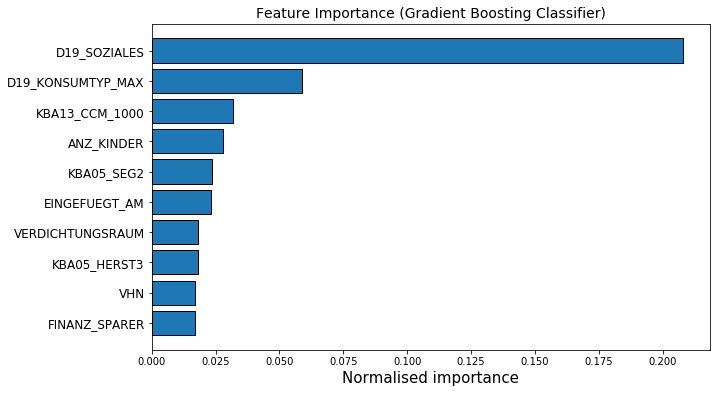

In [164]:
plot_feature_importance(tuned_model, "Gradient Boosting Classifier", mailout_train_MMS.columns)
#mailout_train_MMS.columns

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [143]:
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test = pd.read_csv('/Users/mhashimoto/anaconda2/projects/files/Udacity_MAILOUT_052018_TEST.csv', sep=';')


/Users/mhashimoto/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [144]:
mailout_test_cleaned = data_cleanup(mailout_test)
mailout_test_copy = mailout_test_cleaned.copy()

for row in unknown_meaning.iterrows():
    attribute = row[1]['Attribute']
    value = row[1]['Value']
    
    if attribute in mailout_test_copy.columns:
        if isinstance(value, int):
            mailout_test_copy[attribute].replace(value, np.nan, inplace=True)
        elif isinstance(value, str):
            mailout_test_copy[attribute].replace(str(value), np.nan, inplace=True)

In [145]:
submission = pd.DataFrame(mailout_test_copy['LNR'])
mailout_test_copy = mailout_test_copy.drop('LNR', axis=1, inplace=False)
mailout_test_copy = mailout_test_copy.drop(common_attr, axis=1, inplace=False)
processed_mailout_test = pre_processing(mailout_test_copy)
processed_mailout_test.isnull().sum().sum()

mailout_test_MMS = pd.DataFrame(MinMaxScaler().fit_transform(processed_mailout_test), columns=processed_mailout_test.columns)

0

In [147]:
submission['RESPONSE'] = tuned_model.predict(mailout_test_MMS)
submission.to_csv('/Users/mhashimoto/anaconda2/projects/files/Submissioin.csv', index=False)